# Clustering 3K PBMCs with Adversarial Autoencoders

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results, plot_results_pca, plot_results_umap
from AAE import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Import dataset

!mkdir ../data
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz -O ../data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
!cd ../data; tar -xzf pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz

## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../data/pbmc10k.h5ad'

scanpy==1.4.3 anndata==0.6.20 umap==0.3.9 numpy==1.16.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
            '../data/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
            var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
            cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/..-data-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

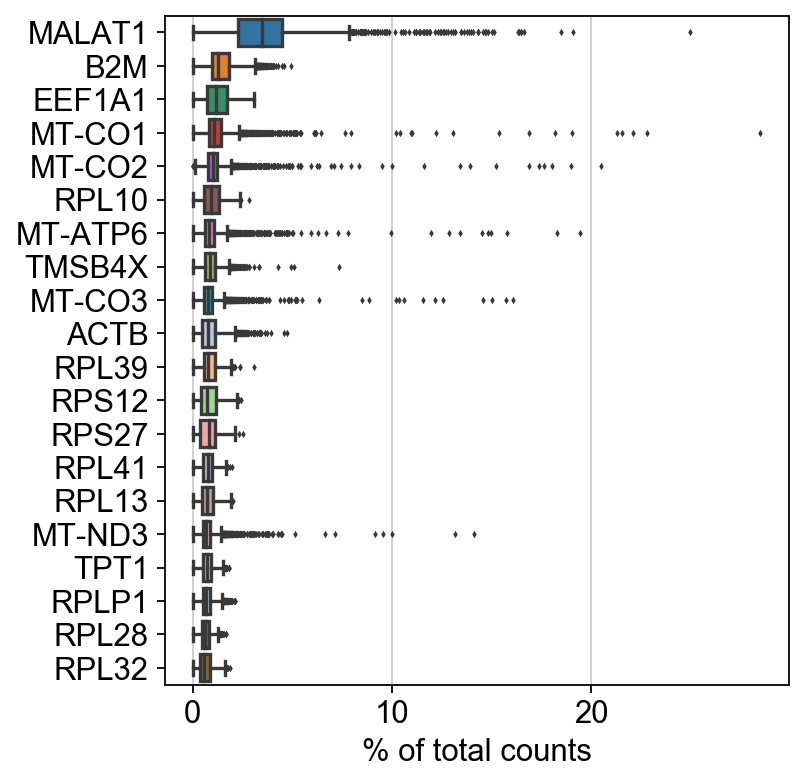

Trying to set attribute `.obs` of view, making a copy.


filtered out 9 cells that have less than 200 genes expressed
filtered out 15484 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)


# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


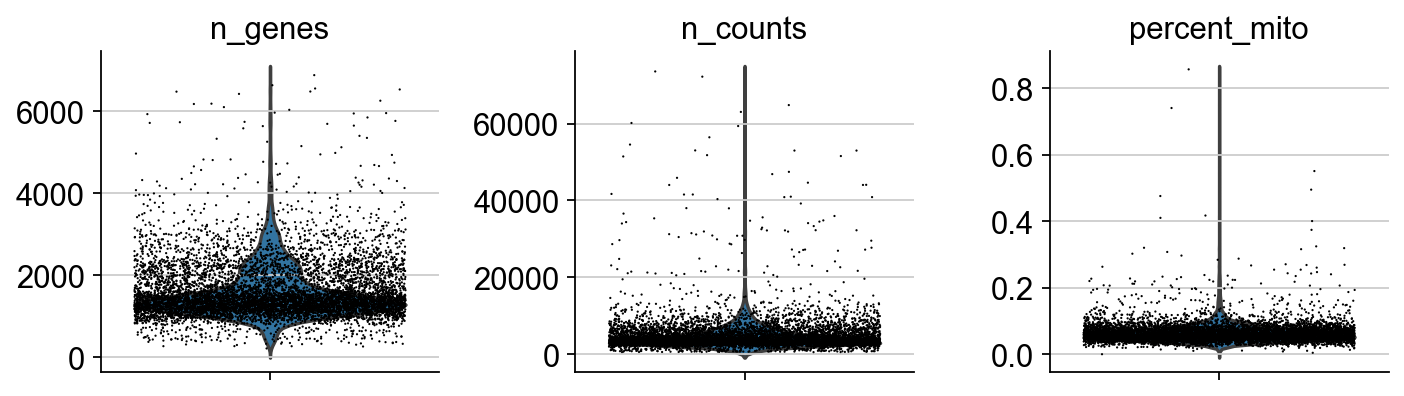

In [9]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

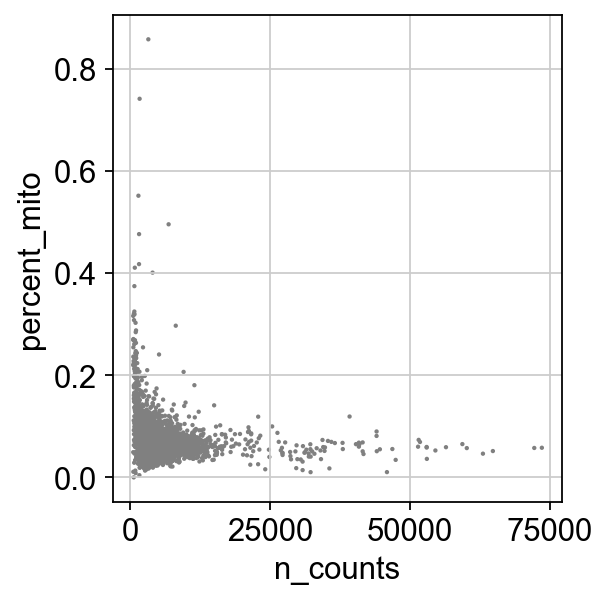

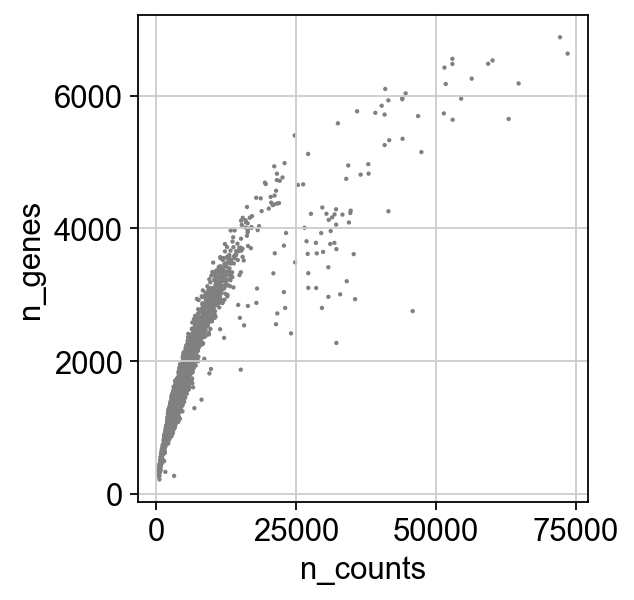

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [12]:
# Data in log scale
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


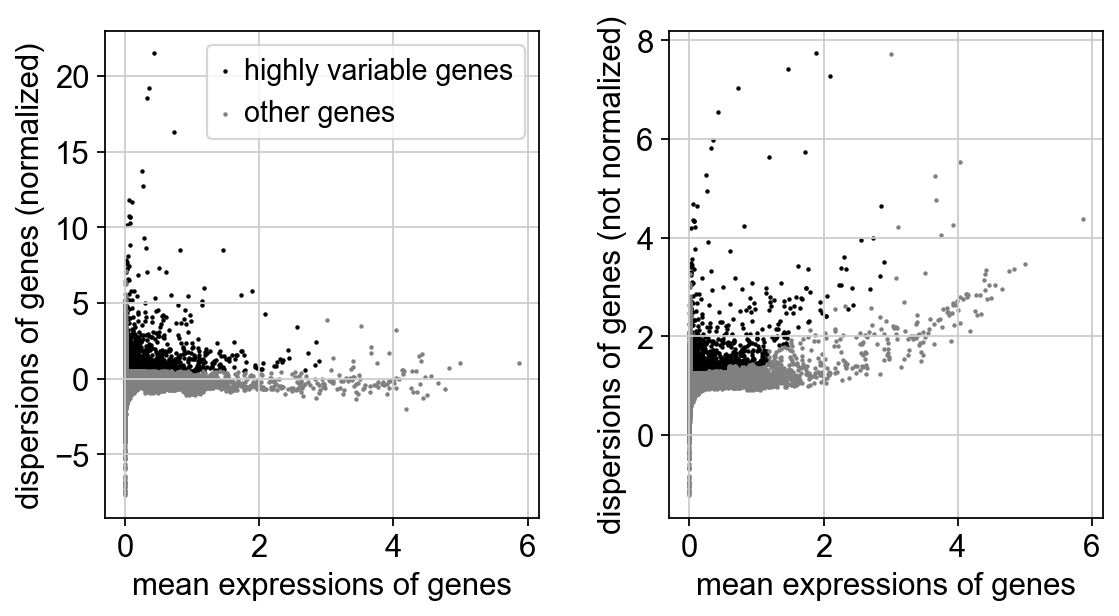

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var['highly_variable']]

In [15]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:14.93)


In [16]:
sc.pp.scale(adata, max_value=10)

In [17]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02.98)


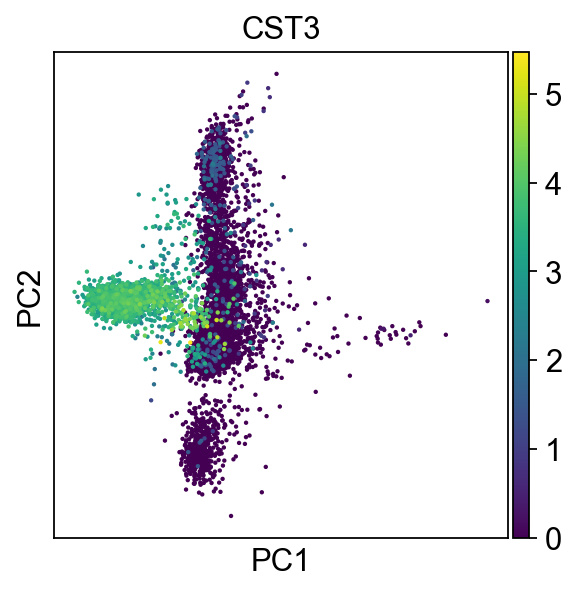

In [18]:
sc.pl.pca(adata, color='CST3')

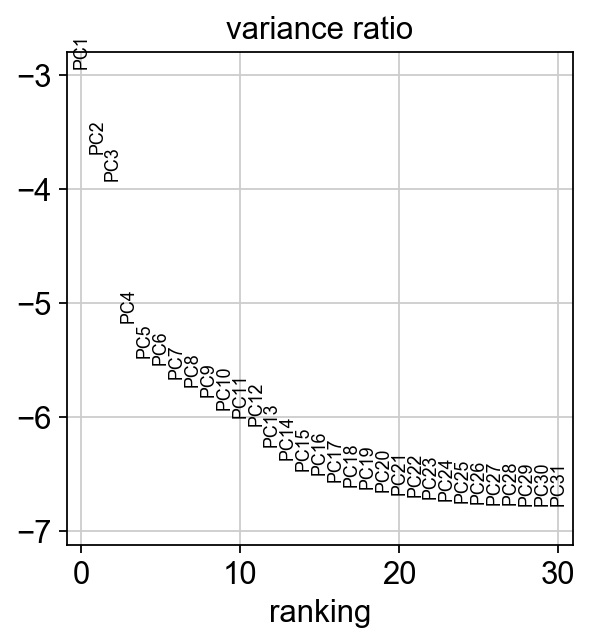

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.25) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [21]:
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 40
    finished (0:00:13.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)


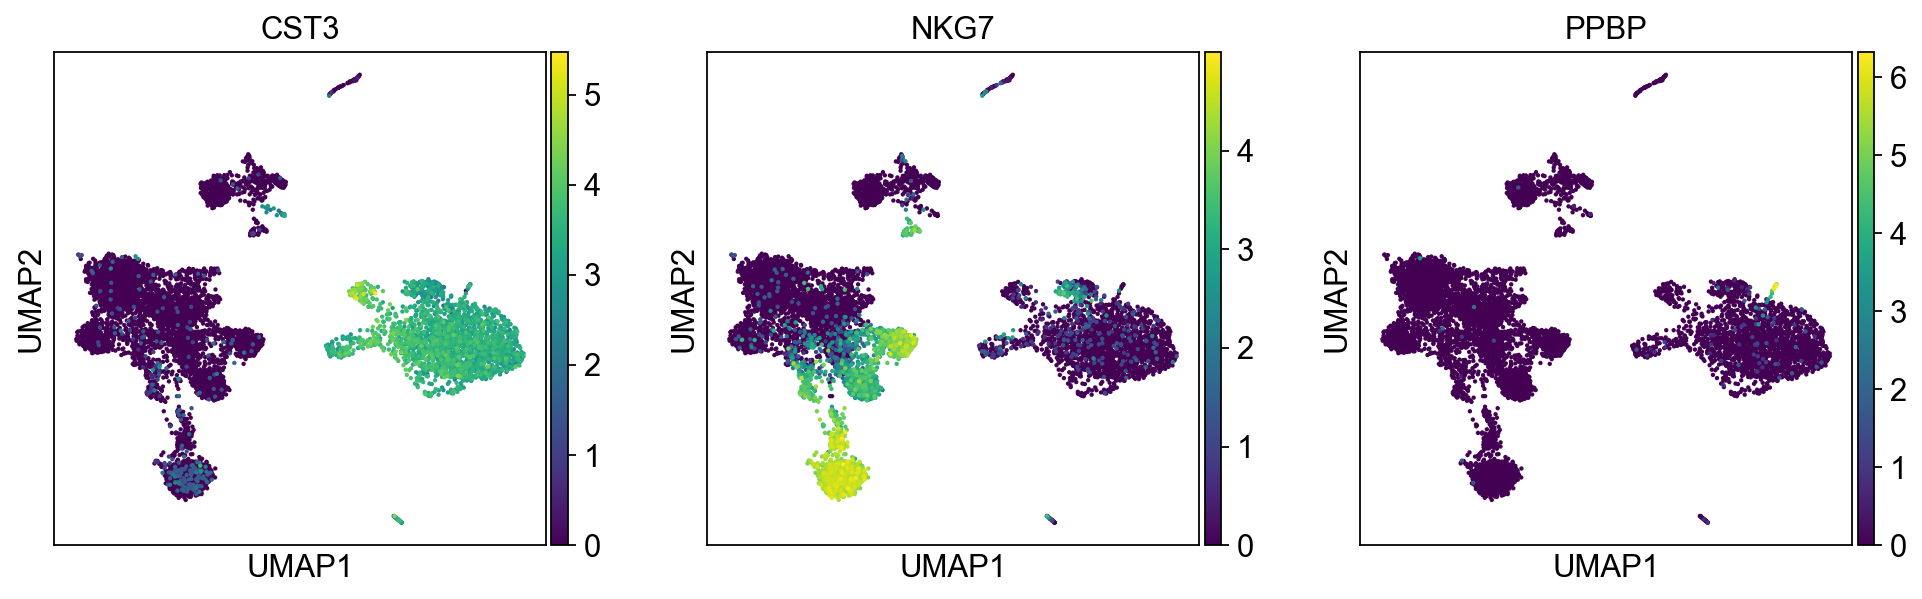

In [22]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [23]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.92) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


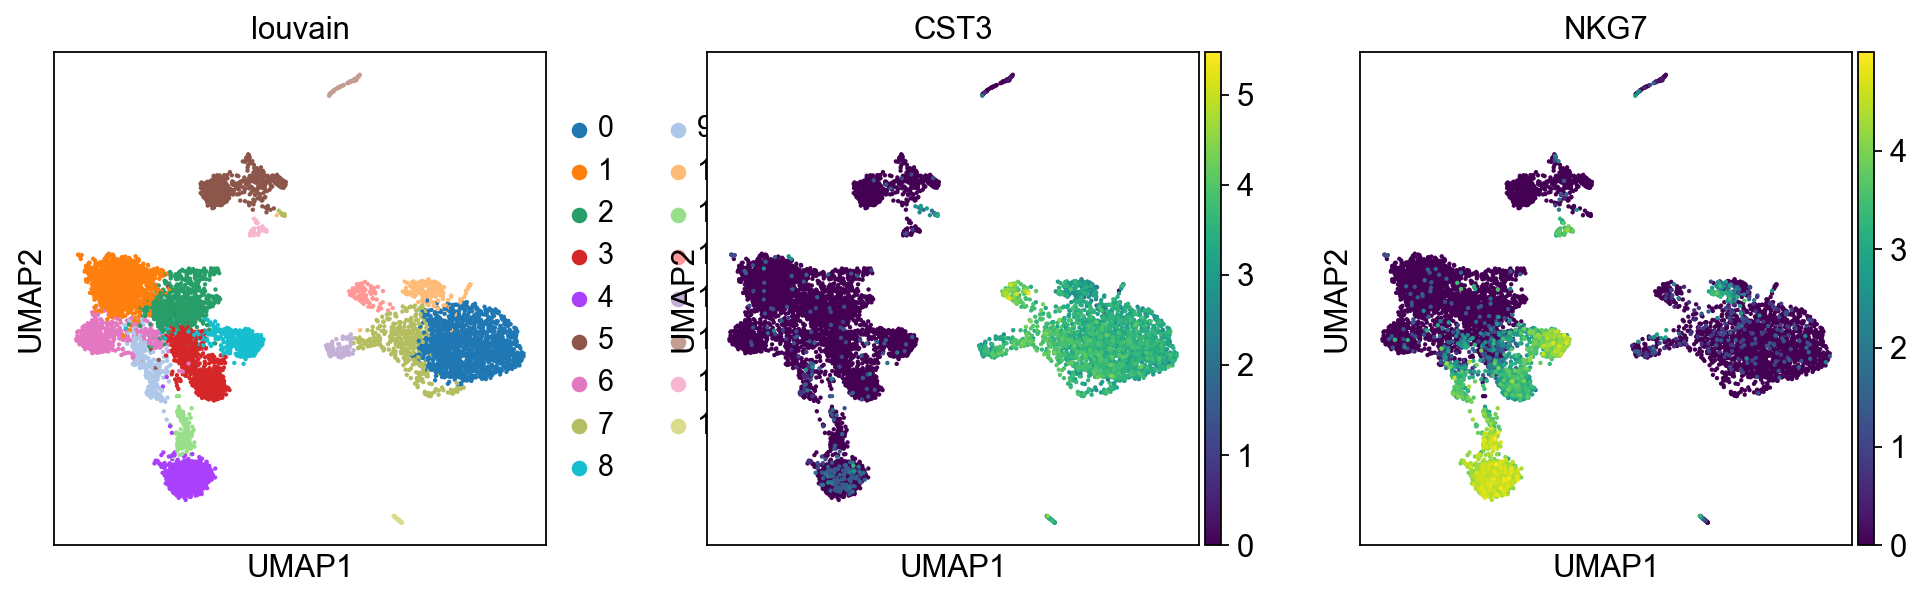

In [24]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

ranking genes
    finished (0:00:09.55) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


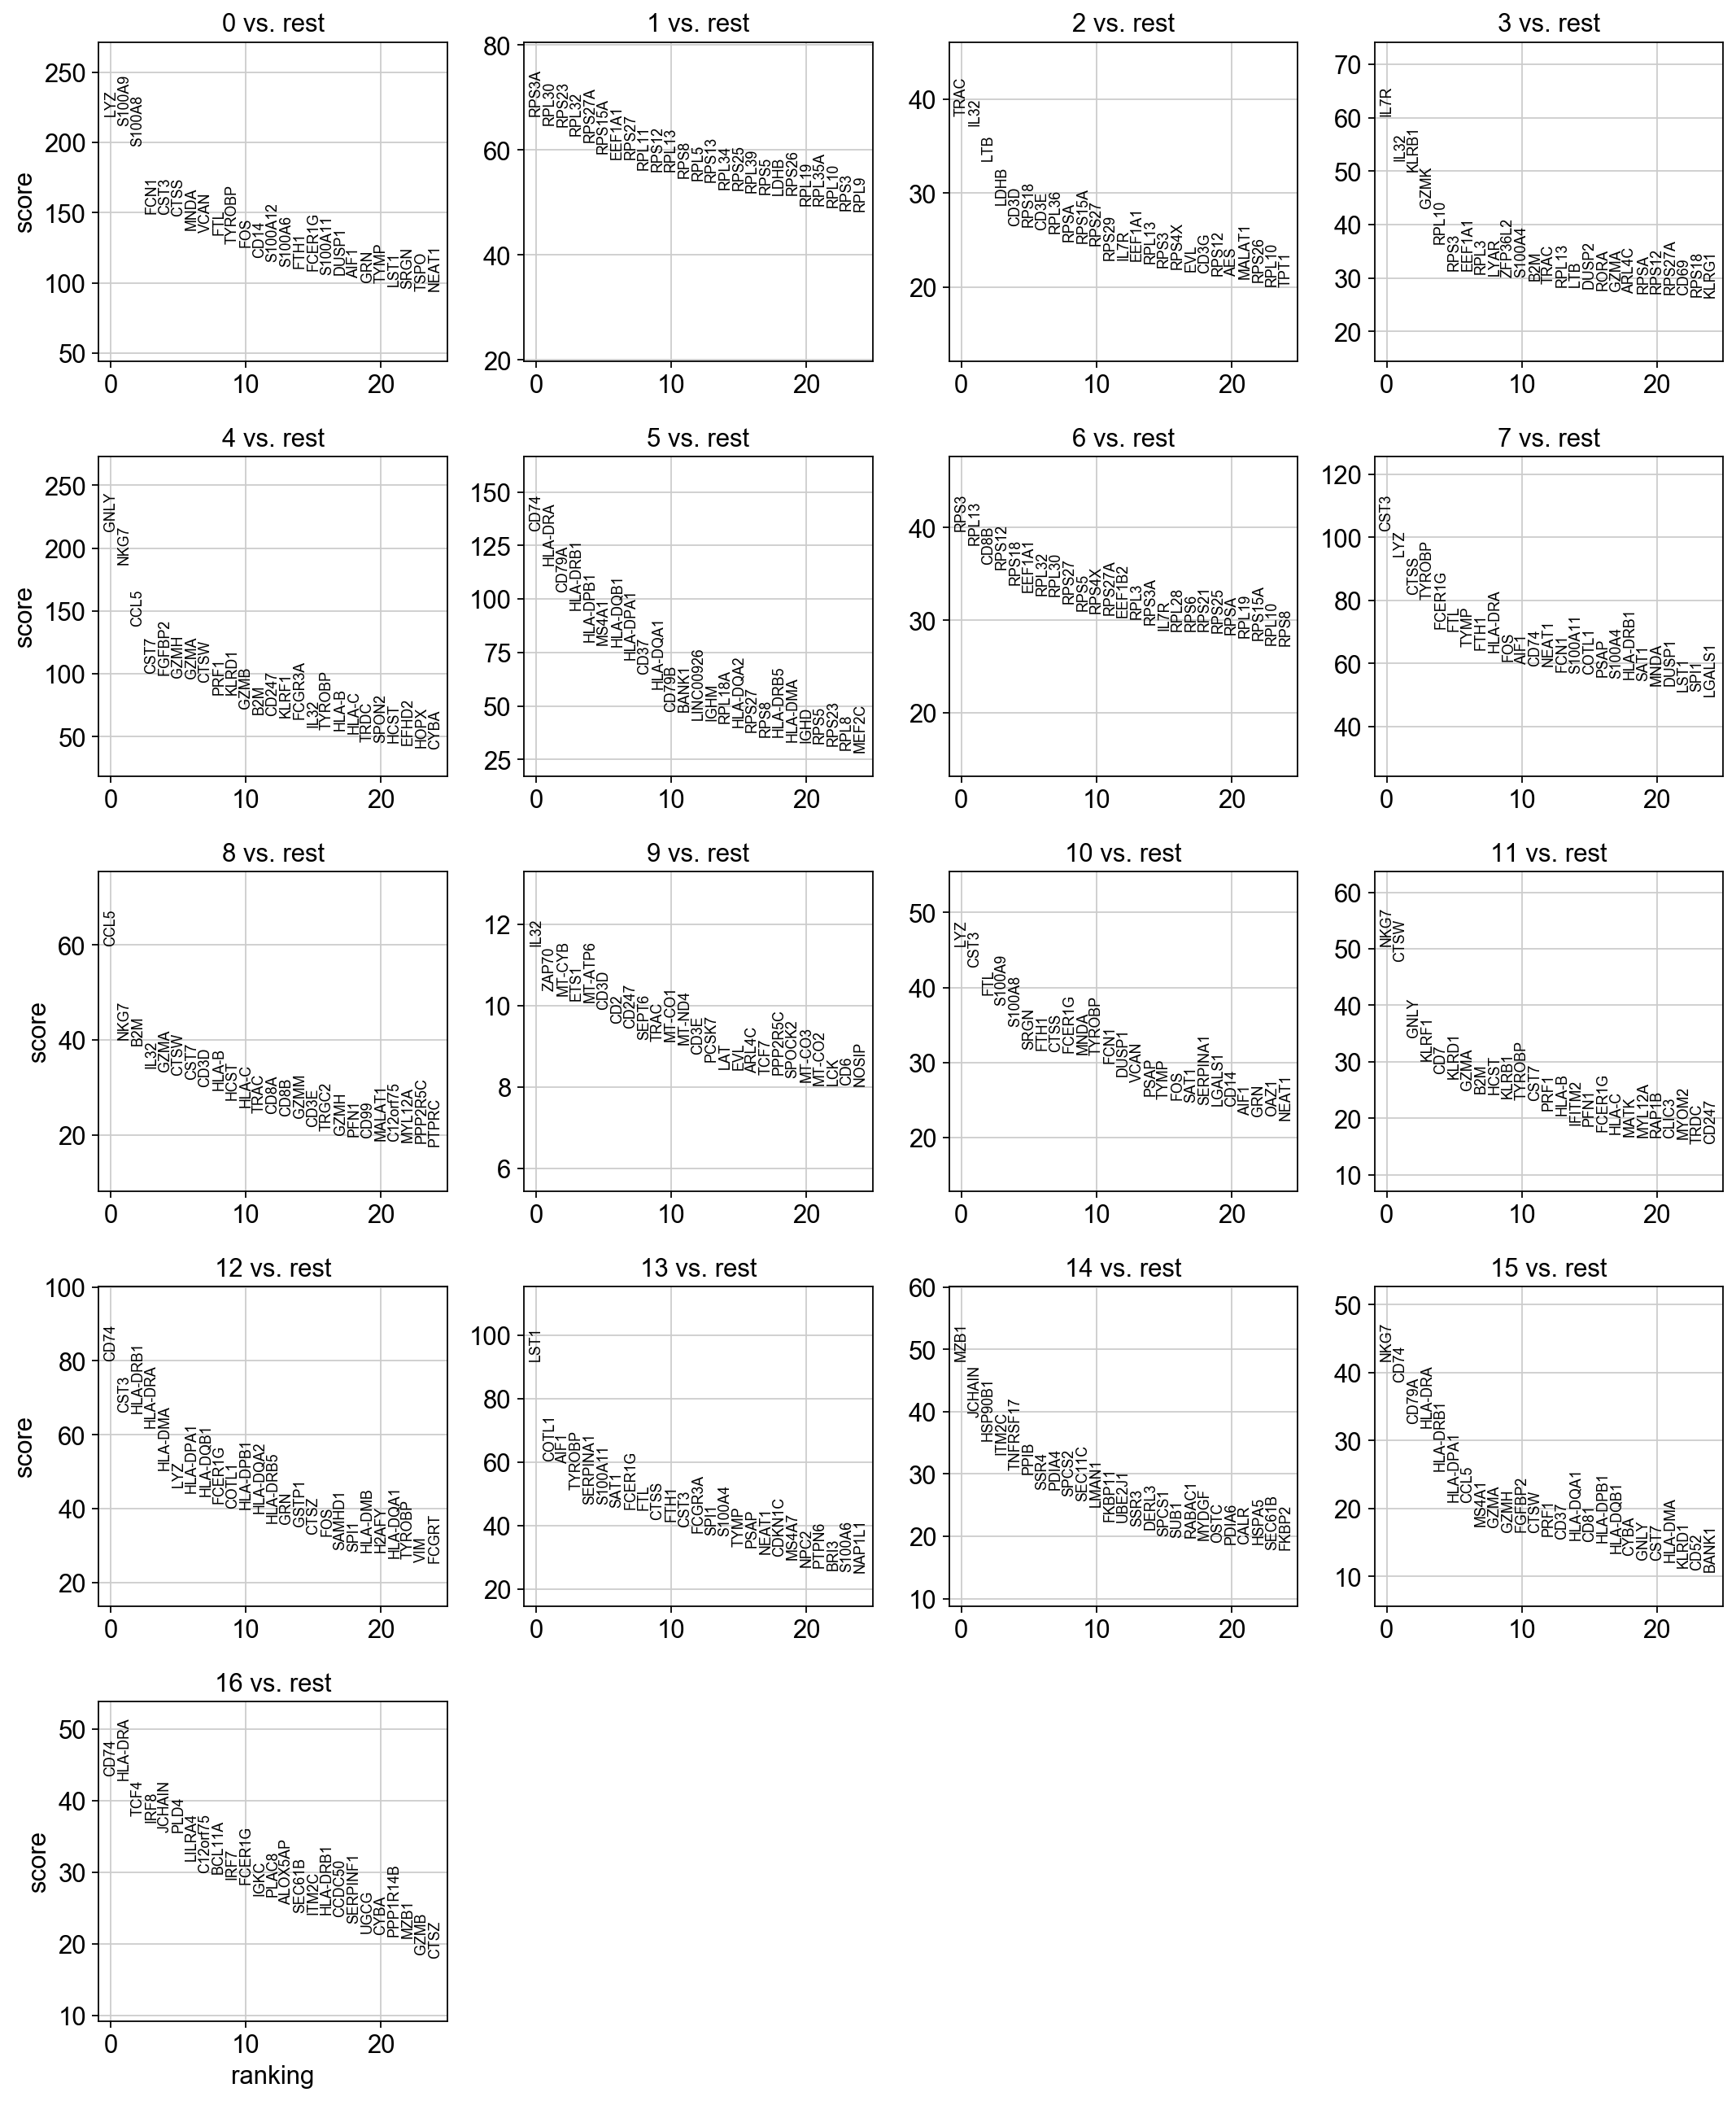

In [25]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

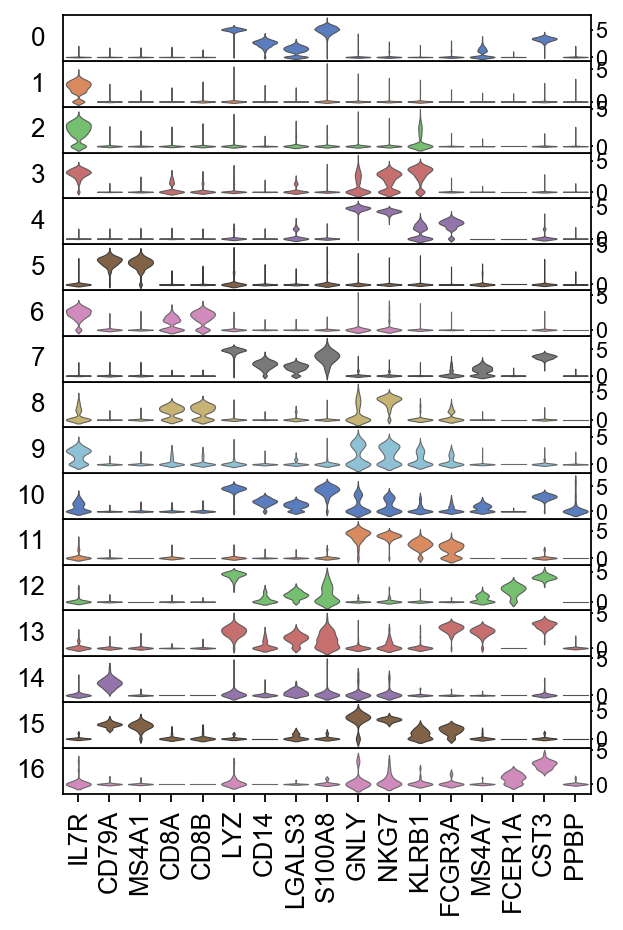

In [27]:
sc.pl.stacked_violin(adata, groupby='louvain', var_names=marker_genes)

In [28]:
#Louvain    Markers       Cell Type
#0          IL7R, CD4     T cells
#1          CD14, LYZ     CD14+ Monocytes
#2          MS4A1         B cells
#3          CD8A, CD8     T cells
#4          GNLY, NKG7    NK cells
#5          FCGR3A, MS4A7 FCGR3A+ Monocytes
#6          FCER1A, CST3  Dendritic Cells
#7          PPBP          Megakaryocytes

new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

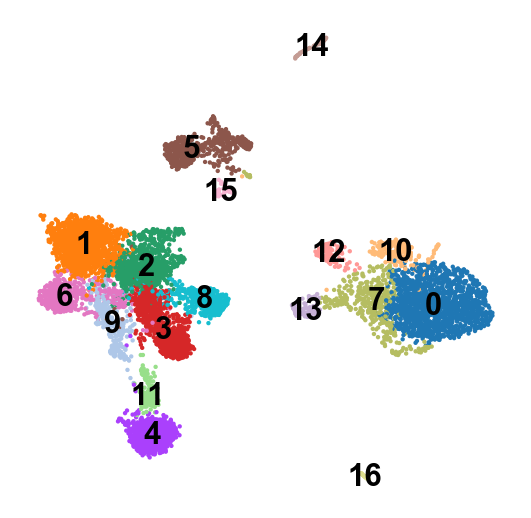

In [29]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False)

In [30]:
adata.obs.shape

(7756, 4)

In [31]:
adata.obs.head()

,n_genes,percent_mito,n_counts,louvain
0,,,,
AAACCCAAGATTGTGA-1,2194,0.084903,6160.0,0
AAACCCACATCGGTTA-1,2093,0.061820,6713.0,0
AAACCCAGTACCGCGT-1,1518,0.078911,3637.0,0
AAACCCAGTATCGAAA-1,737,0.088424,1244.0,4
AAACCCAGTCGTCATA-1,1240,0.059747,2611.0,4


In [32]:
adata.var.shape

(1972, 7)

In [33]:
adata.var.head()

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
HES4,ENSG00000188290,Gene Expression,131,True,0.045170,1.462180,1.151113
ISG15,ENSG00000187608,Gene Expression,2282,True,0.697626,1.660043,1.234033
C1orf159,ENSG00000131591,Gene Expression,223,True,0.070364,1.314917,0.663855
TNFRSF18,ENSG00000186891,Gene Expression,373,True,0.133355,1.470949,1.180127
TNFRSF4,ENSG00000186827,Gene Expression,533,True,0.207609,1.508394,1.304025


In [34]:
adata.var_names

Index(['HES4', 'ISG15', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'AL645728.1',
       'MIB2', 'MMP23B', 'MORN1', 'TNFRSF14-AS1',
       ...
       'MX1', 'PWP2', 'AP001059.3', 'AP001059.2', 'COL6A2', 'LSS', 'C21orf58',
       'PCNT', 'DIP2A', 'S100B'],
      dtype='object', length=1972)

In [35]:
gene_names = adata.var_names.values

In [36]:
data = adata.X
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


### embedding

In [37]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [38]:
genes_encoder = LabelEncoder()
genes_encoded = genes_encoder.fit_transform(gene_names)
print(genes_encoded)

[ 820  942  322 ... 1330  580 1538]


In [39]:
genes_OHE = to_categorical(genes_encoded)

In [40]:
from numpy import argmax

inverted = genes_encoder.inverse_transform([argmax(genes_OHE[0, :])])
print(inverted)

['HES4']


In [41]:
inverted = argmax(genes_OHE[0])
print(inverted)

820


## Adversarial Autoencoder Model

### Network parameters

In [42]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 50
layer_3_dim = 50
batch_size = 35 #128
latent_dim = 50
epochs = 75

In [43]:
encoder, decoder, discriminator, generator, aae = build_AAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1972)         0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 1972)         0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          197200      DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

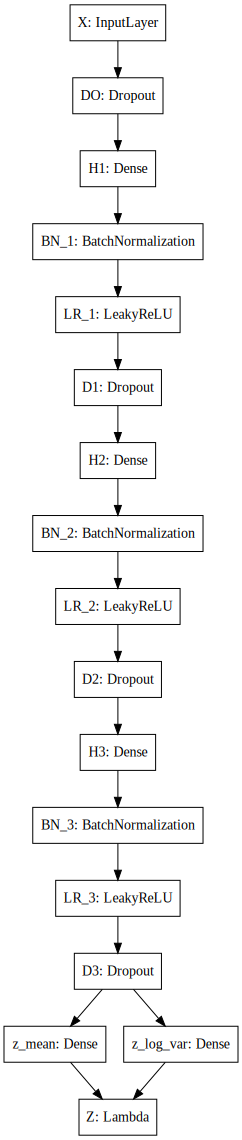

In [44]:
print("\nEncoder Network")
print("===============")
encoder.summary()
os.makedirs('../graphs', exist_ok=True)
plot_model(encoder, to_file='../graphs/aae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)                2500

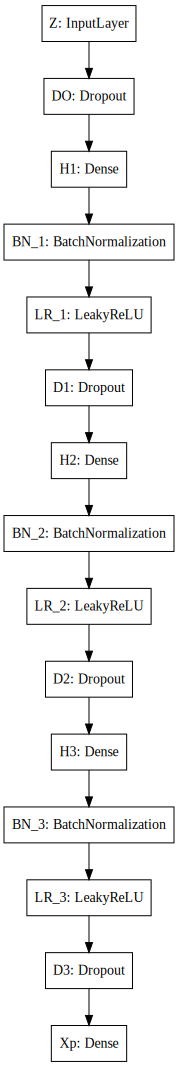

In [45]:
print("\nDecoder Network")
print("===============")
decoder.summary()
plot_model(decoder, to_file='../graphs/aae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
decoder (Model)              (None, 1972)              209972    
Total params: 420,572
Trainable params: 419,772
Non-trainable params: 800
_________________________________________________________________


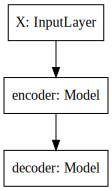

In [46]:
print("\nAutoencoder Network")
print("===================")
aae.summary()
plot_model(aae, to_file='../graphs/aae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))


Generator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
discriminator (Model)        (None, 1)                 10901     
Total params: 221,501
Trainable params: 220,701
Non-trainable params: 800
_________________________________________________________________


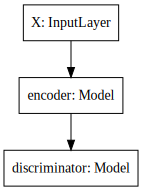

In [47]:
print("\nGenerator Network")
print("===================")

# Freeze the discriminator weights during training of generator
#generator.get_layer('discriminator').trainable = False 
generator.summary()
plot_model(generator, to_file='../graphs/aae_generator.png', show_shapes=True)
SVG(model_to_dot(generator).create(prog='dot', format='svg'))


Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)              

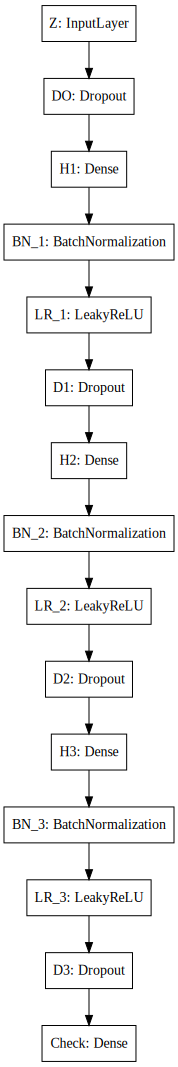

In [48]:
print("\nDiscriminator Network")
print("=====================")

#discriminator.trainable = True
discriminator.summary()
plot_model(discriminator, to_file='../graphs/aae_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

### Model training

Epoch 75/75, reconstruction loss: 0.972942, generation loss: 0.075826, discriminator loss: 0.297125


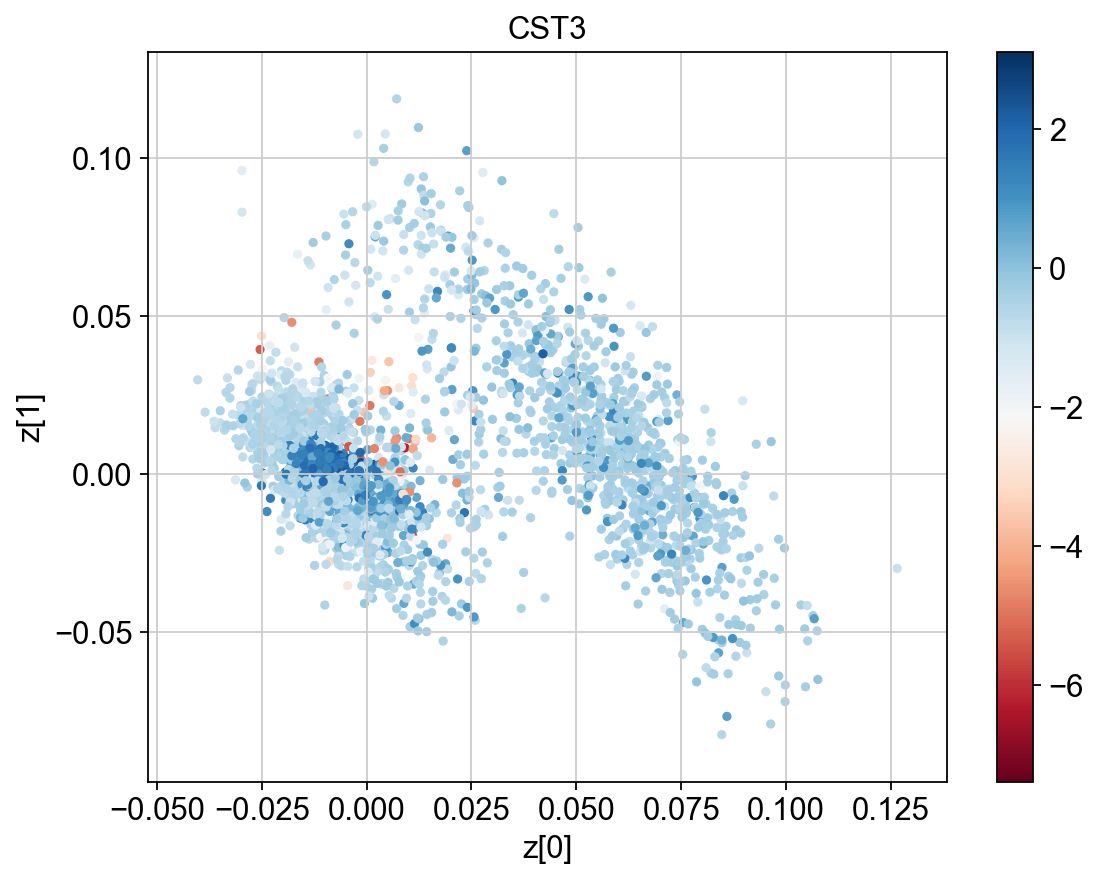

In [49]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = train_AAE(aae, generator, discriminator, encoder, decoder,
                                          data, batch_size, latent_dim, epochs, 
                                          gene, gene_names, graph=True, 
                                          val_split=0.0)

# save models
os.makedirs('../models', exist_ok=True)
aae.save('../models/aae_autoencoder.h5')
generator.save('../models/aae_generator.h5')
encoder.save('../models/aae_encoder.h5')
decoder.save('../models/aae_decoder.h5')
discriminator.save('../models/aee_discriminator.h5') 

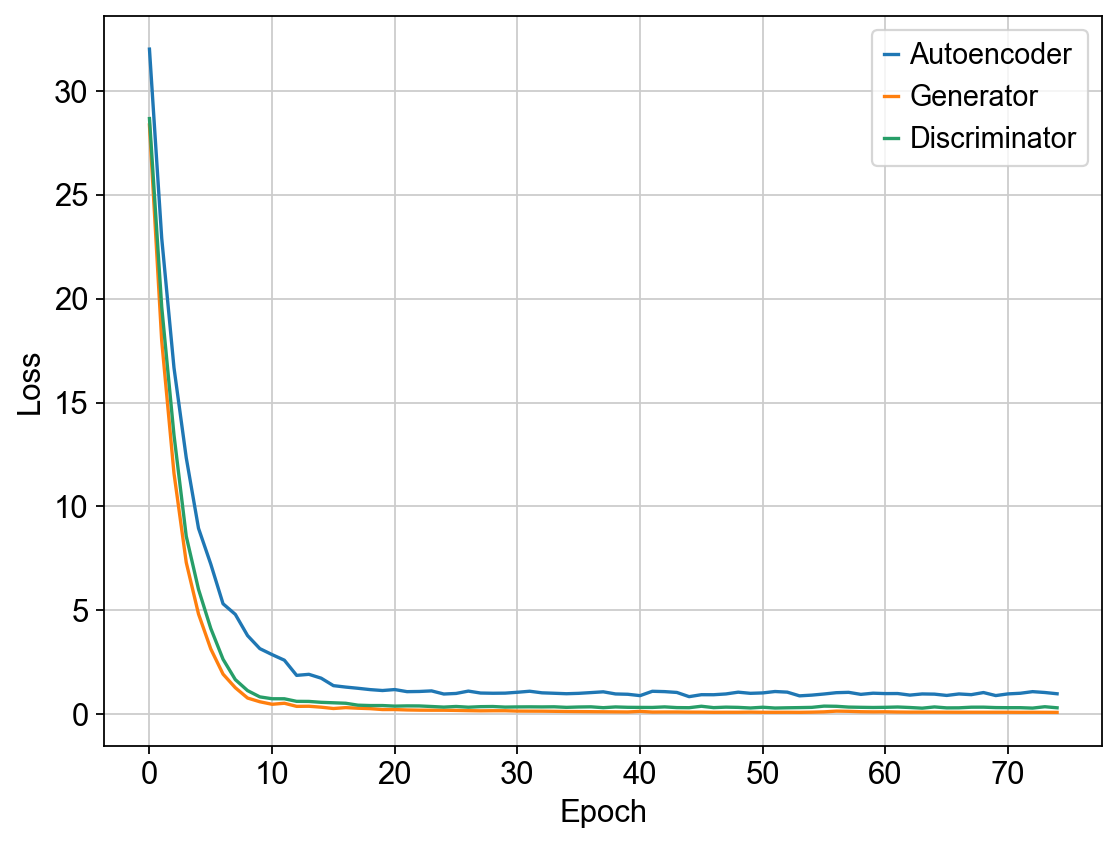

In [53]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

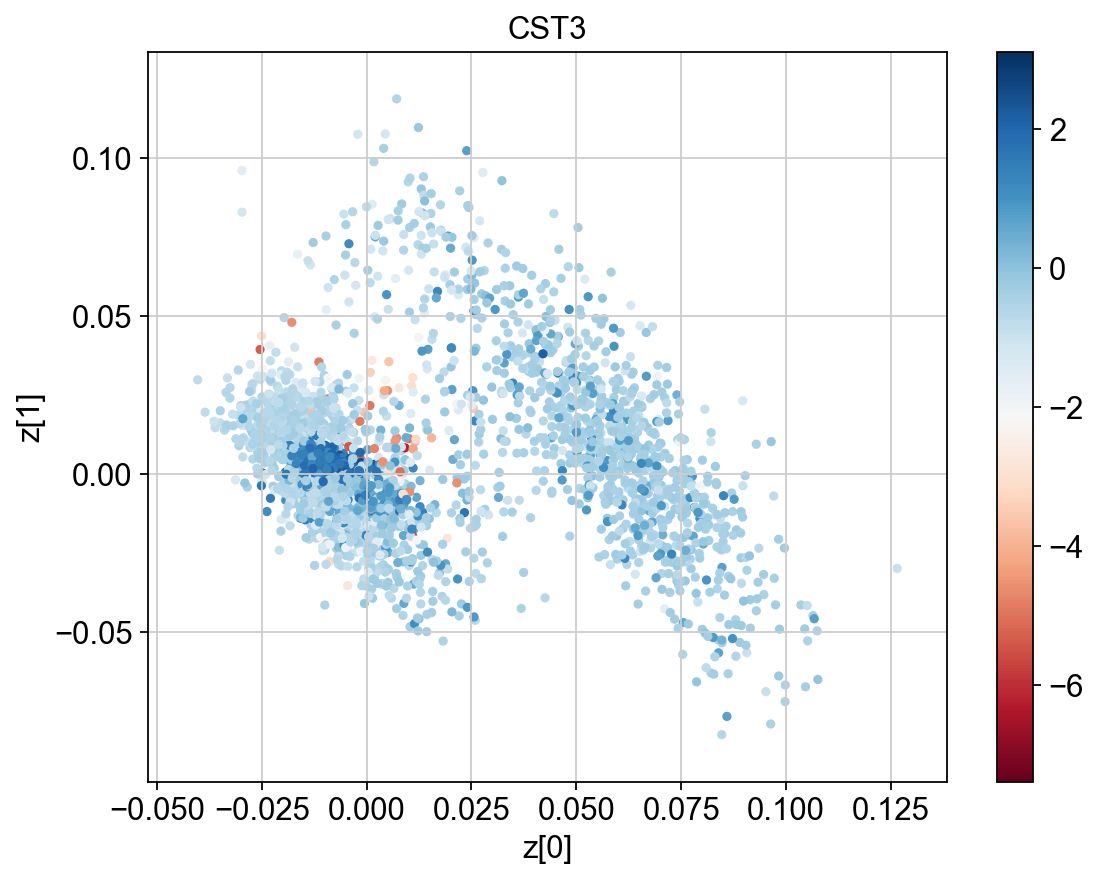

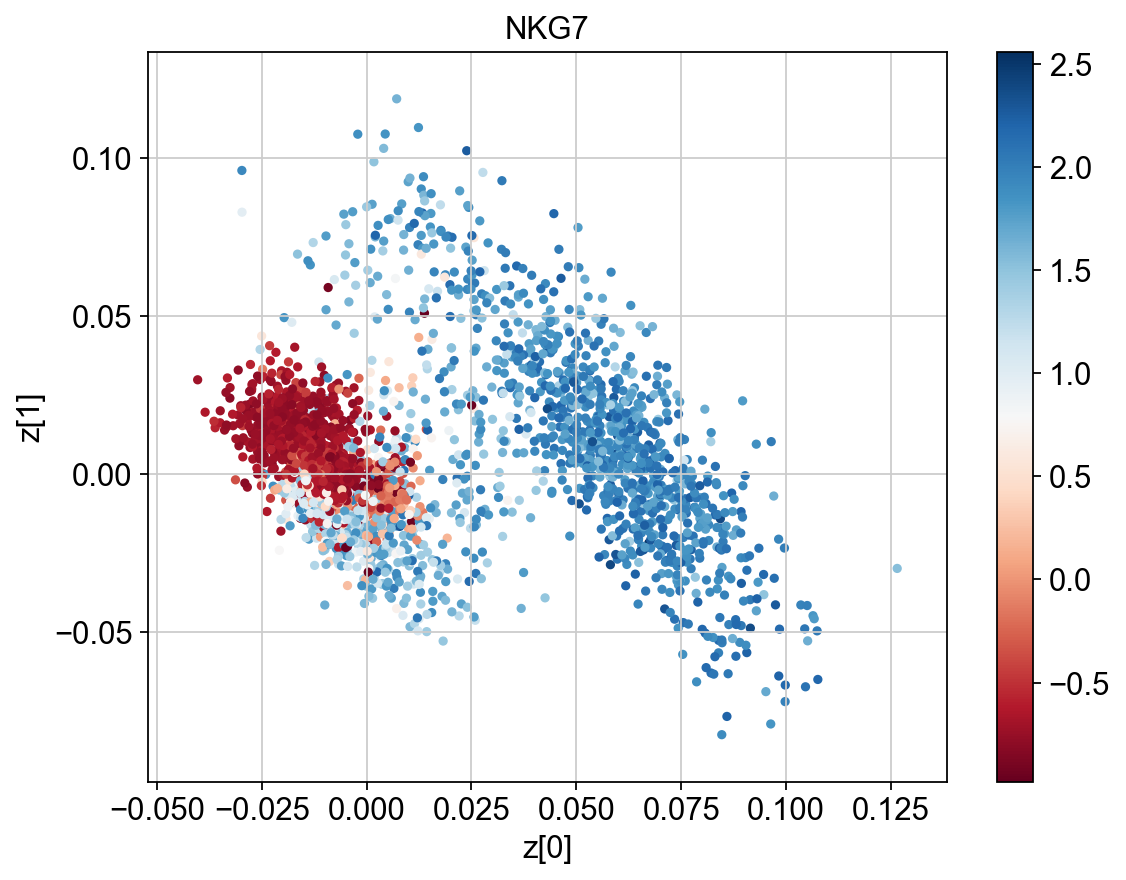

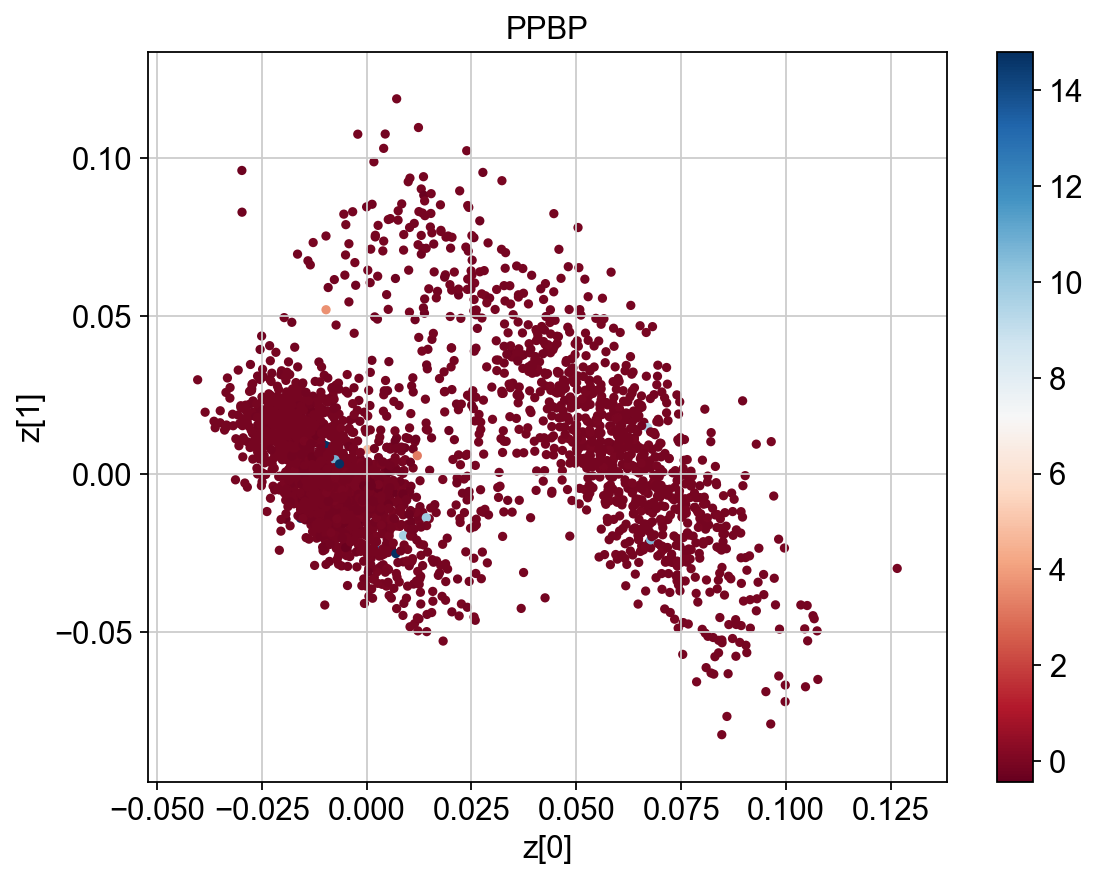

In [54]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

pca = PCA(n_components=2500)
pca.fit(data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

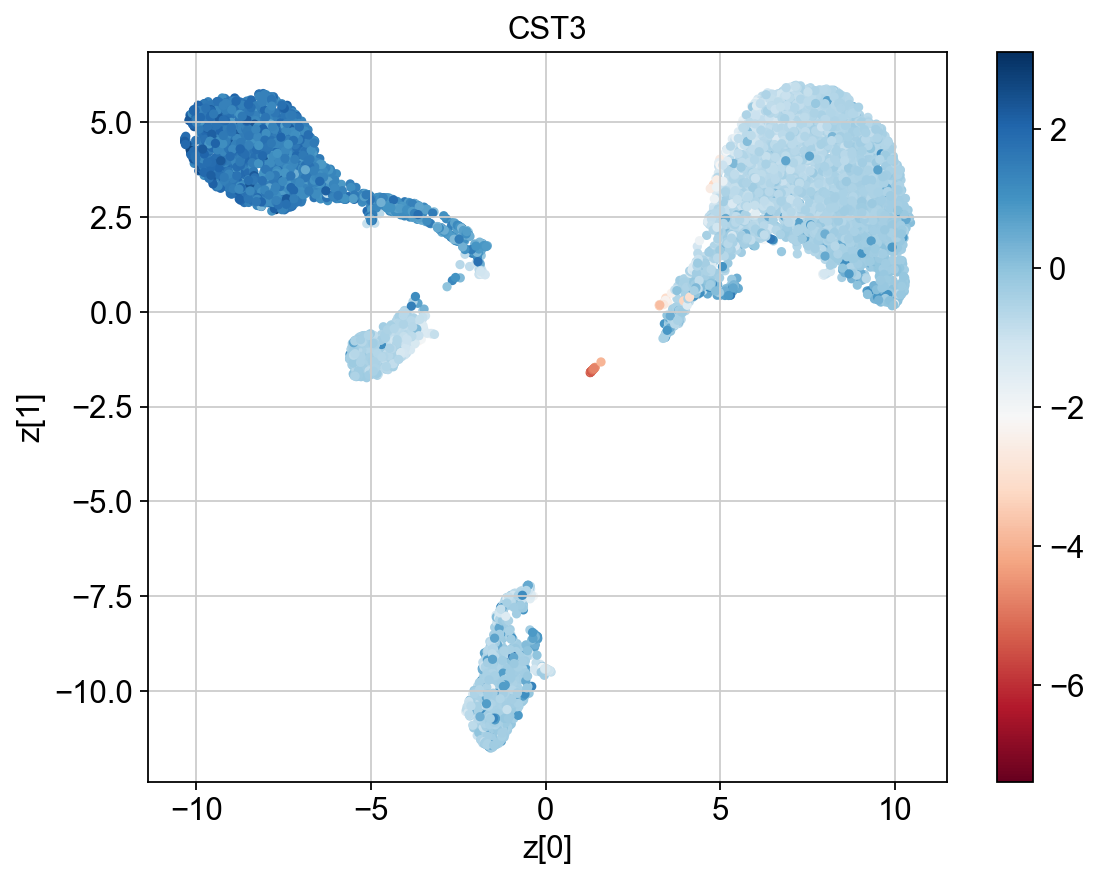

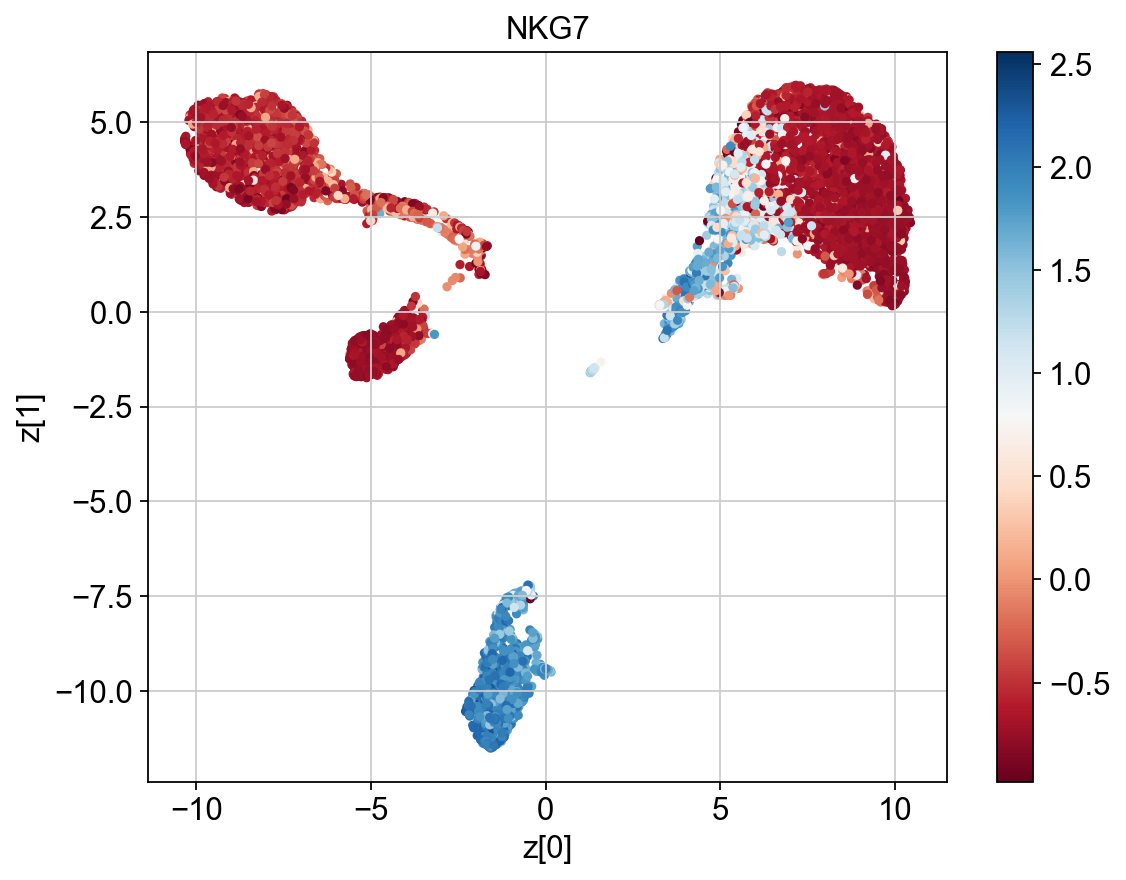

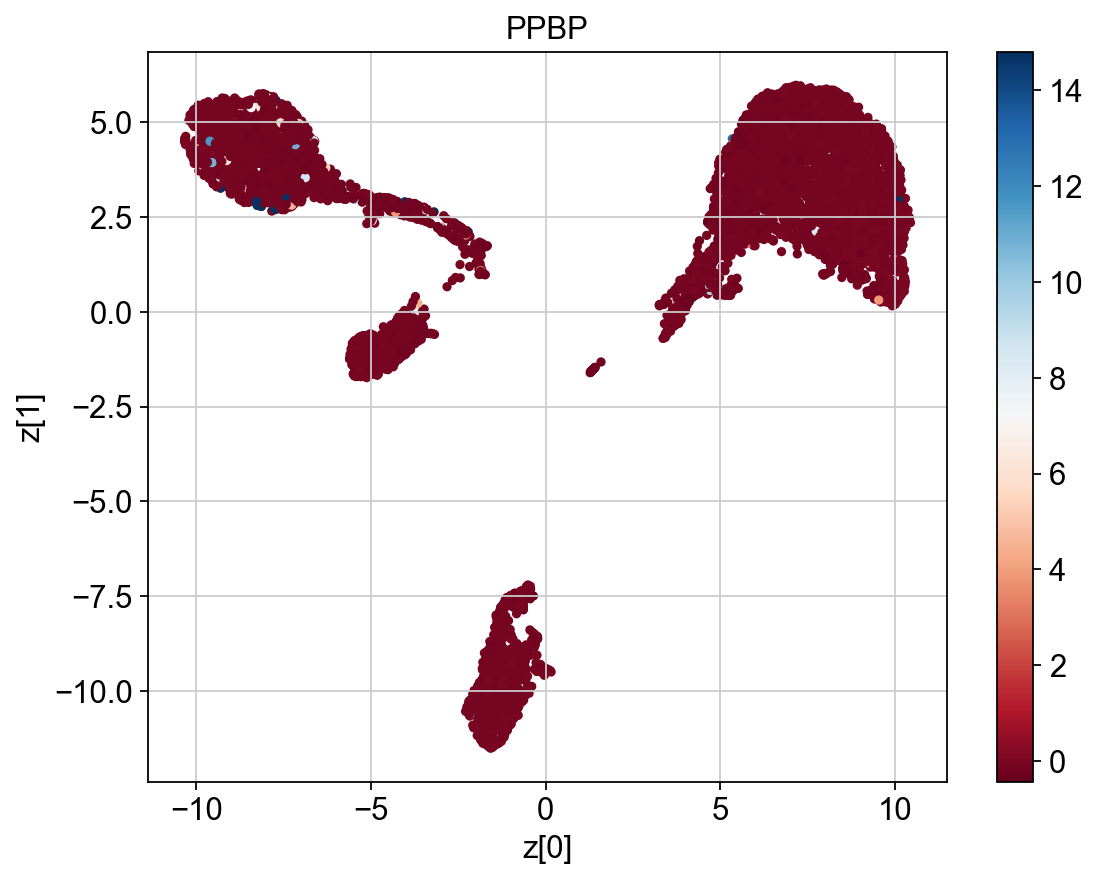

In [55]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_umap(models, data, gene_list, gene_names, latent_dim)